# Entrenamiento y análisis de YOLO en el dataset de piccolo
_Santiago Prieto Núñez_

#### Objetivo
En este Jupiter Notebook utilizaremos yolos-base de hugging face como modelo
preentrenado para la detección de polipos en imágenes del dataset de Piccolo.

Pasos a seguir:
1. Procesar el dataset de piccolo y hacer un análisis exploratorio de los datos
2. Modificar el modelo de yolos-base para tener solo las bbox de salida
3. Entrenar el modelo de hugging face con los nuevos datos
4. Analizar el rendimiento del modelo

## Piccolo dataset

En este dataset es el que usaremos, es un dataset muy completo con máscaras binarias 
y metadatos de cada pólipo, además está ya dividio en test train y validation
ya que hay grupos de imágenes del mismo pólipo. Por lo que **seguiremos el split original** 
del dataset **para comparar los resultado**s con el del estudio original

**Analiazaremos el datset creado**, **obteniendo** datos del mismo como **las bbox** del pólipo

In [31]:
from utils import ImageDatasetProcessor as idp
import os

json_path = "datasets/piccolo_dataset/piccolo_dict.json"

# paths del dataset
paths_img = [
    # train paths
    ("datasets/piccolo_dataset/test/polyps",                    # polyps
     "datasets/piccolo_dataset/test/masks",                     # masks
     "datasets/piccolo_dataset/test/void", "test"  ,            # voids
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),    # light type

    # test paths
    ("datasets/piccolo_dataset/train/polyps",
     "datasets/piccolo_dataset/train/masks",
     "datasets/piccolo_dataset/train/void", "train",
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),

    # validation paths
    ("datasets/piccolo_dataset/validation/polyps",
     "datasets/piccolo_dataset/validation/masks",
     "datasets/piccolo_dataset/validation/void", "validation",
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv")
    ]

# inicializamos el dataset con su nombre y fichero de formatos de imagen
dt_Piccolo = idp(target_resolution=(400, 240), dataset_name="Piccolo",
                     json_path=json_path)

# procesamos el dataset si no existe el json
if not os.path.isfile(json_path):
    for path in paths_img:
        print(f"procesando conjunto: {path[3]}")
        dt_Piccolo.load_dataset(path[0], path[1], voids_path=path[2], 
                                split=path[3], light_csv=path[4])

#### Análisis del dataset
Como podemos ver es un dataset muy ordenado, con una cantidad representativa de
imágenes NBI por lo que es adecuado para el entrenamiento en ambos tipos de luz 
(WL, NBI).

Además podemos observar que es un dataset con una distribución de los pólipos
más o menos descentralizada.

In [32]:
dt_Piccolo.print_summary()

Total imágenes: 3433
Composición del dataset:
Resoluciónes: total distintas resoluciones 2
	480x854: 1972	1080x1920: 1461

Tipos de luz:
	WL: 2131	NBI: 1302

Splits:
	test: 333	train: 2203	validation: 897

Canales:
	polyp_RGB: 3433	mask_L: 3433	void_L: 3433

Volumen medio de los pólipos respecto a la imagen:	20.195122875106236%
Distancia media del centro del pólipos al centro de la imagen:	55.30091482169522px


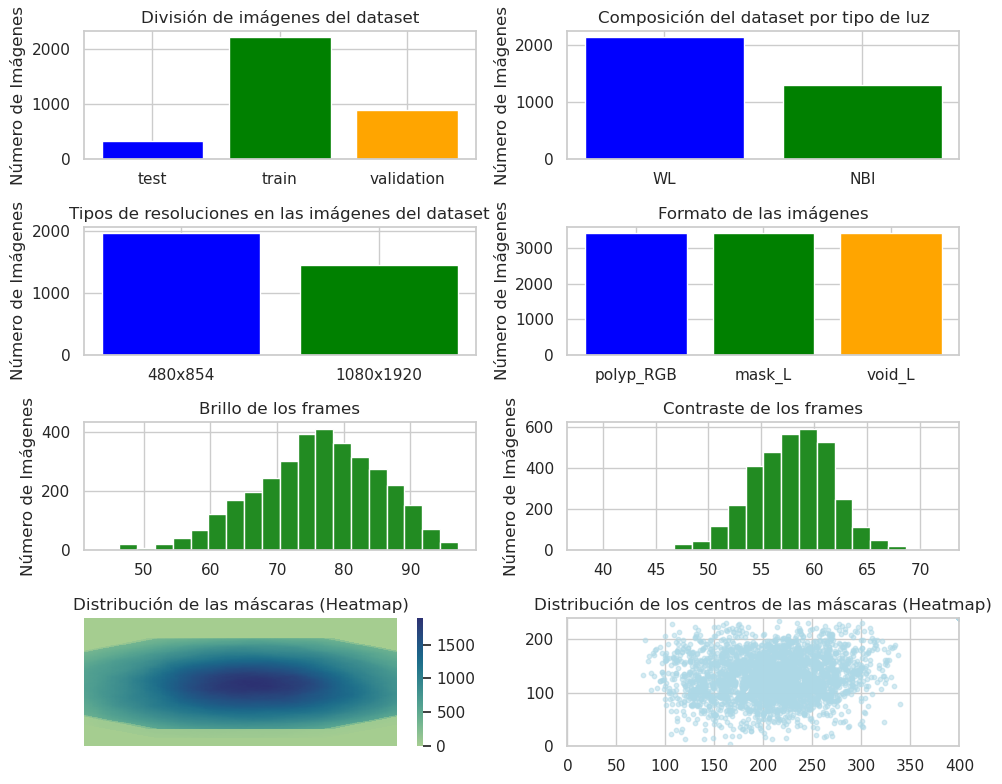

In [33]:
dt_Piccolo.graph_summmary()

Finalmente veamos una muestra de una imágen aleatoria y su aspecto con la bbox

Imagen 035_VP31_frame1808.png	bbox: (1340, 929, 164, 150)


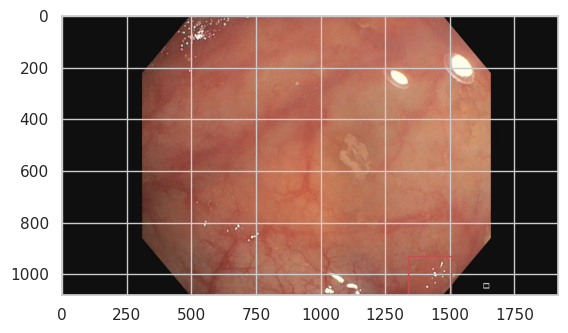

In [34]:
import random

# mostramos aleatoriamente una imágen del dataset
rand_key = random.choice(list(dt_Piccolo.dict.keys()))
dt_Piccolo.show_image(rand_key)


## Entrenamiento de YOLO

Para esta segunda entrenaremos el modelo de [yolos-base](https://huggingface.co/hustvl/yolos-base)
con las imágenes del dataset de Piccolo, con la peculiaridad que trataremos con 
un modelo modificado para devolver solo las bboxes.

#### Pasos del entrenemiento
1. **Modificaremos el modelo** para entrenar y devolver tan solo las bboxes ya que 
YOLO tiene dos MLP de salida que recogen los mismos datos del encoder, estas
son las **dos salidas de yolo** que son el clasificador de clases de COCO y las
bbox que localizan este objeto, **solo nos interesa la segunda**

2. **Preparar todo para el entrenamiento**, esto son elementos como el 
optimizador y la función de pérdida además de juntar definitivamente los datos
en los splits adecuados y DataLoaders para usarlos en la función de entrenamiento

3. **Entrenar** el modelo y ir obteniendo datos del rendimiento del mismo para
poder mostrarlos más adelante